### This is a notebook which tested the accuracy of a network built solely of Fully Connected layers. Then the FGSM was tested

### Imports

In [1]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.io
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
from sklearn import metrics
import math
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Dataset

In [29]:
batch_size = 100

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


### Model

In [36]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 10)

        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)  
    

def train_classifier(cl, opt, x, y):
    x.to(device)
    y.to(device)
    #Reset gradients
    opt.zero_grad()
    #Train on real data
    pred = cl(x)
    pred.to(device)
    err = F.nll_loss(pred, y)
    err.backward()
    #Update optimizer
    opt.step()
    return err, pred

def test_model(cl,test_loader): 
    correct = 0
    with torch.no_grad():
        cl.eval()
        for data, target in test_loader:
            data = data.reshape(-1, 28*28)
            output = cl(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_loader.dataset))
        
    return acc_test

### Train classifier

In [37]:
num_epochs = 7
e_losses = [] 

# Load pre-trained model
cl = Classifier().to(device)

# optimizer
cl_opt = optim.Adam(cl.parameters(), lr=0.001, weight_decay=0)

for e in range(num_epochs):
    cl.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.reshape(-1, 28*28)
        c_error,c_pred = train_classifier(cl,cl_opt, data.to(device), target.to(device)) # train with new_batch
        e_losses.append(c_error.cpu().data.numpy())
    acc = test_model(cl,test_loader)
    print("Epoch ", e, ": Test accuracy: ", 100*acc, "%")

print("Performance in the trained model: ")
acc_test = test_model(cl,test_loader)
print("Test accuracy: ", 100*acc_test, "%")
print("FINISHED!!!")

C:\Users\Matach\Anaconda3\envs\fyp\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


Epoch  0 : Test accuracy:  95.67 %
Epoch  1 : Test accuracy:  97.19 %
Epoch  2 : Test accuracy:  97.64 %
Epoch  3 : Test accuracy:  97.69 %
Epoch  4 : Test accuracy:  97.71 %
Epoch  5 : Test accuracy:  98.02 %
Epoch  6 : Test accuracy:  97.92999999999999 %
Performance in the trained model: 
Test accuracy:  97.92999999999999 %
FINISHED!!!


In [38]:
torch.save(cl.state_dict(), './saved_models/FC/vanilla_FC.pth')

# FGSM

### Inputs

In [39]:
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = './saved_models/FC/vanilla_FC.pth'
use_cuda = True

### Model under attack

In [40]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 10)

        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)  
    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
model = Classifier().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Classifier(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

### FGSM attack

In [42]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:
        # Reshape data
        data = data.reshape(-1, 28*28)

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)
        # Zero all existing gradients
        model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward()
        # Collect datagrad
        data_grad = data.grad.data
        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [43]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)
print(accuracies)

C:\Users\Matach\Anaconda3\envs\fyp\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


Epsilon: 0	Test Accuracy = 9793 / 10000 = 0.9793
Epsilon: 0.05	Test Accuracy = 6308 / 10000 = 0.6308
Epsilon: 0.1	Test Accuracy = 1496 / 10000 = 0.1496
Epsilon: 0.15	Test Accuracy = 611 / 10000 = 0.0611
Epsilon: 0.2	Test Accuracy = 237 / 10000 = 0.0237
Epsilon: 0.25	Test Accuracy = 76 / 10000 = 0.0076
Epsilon: 0.3	Test Accuracy = 35 / 10000 = 0.0035
[0.9793, 0.6308, 0.1496, 0.0611, 0.0237, 0.0076, 0.0035]


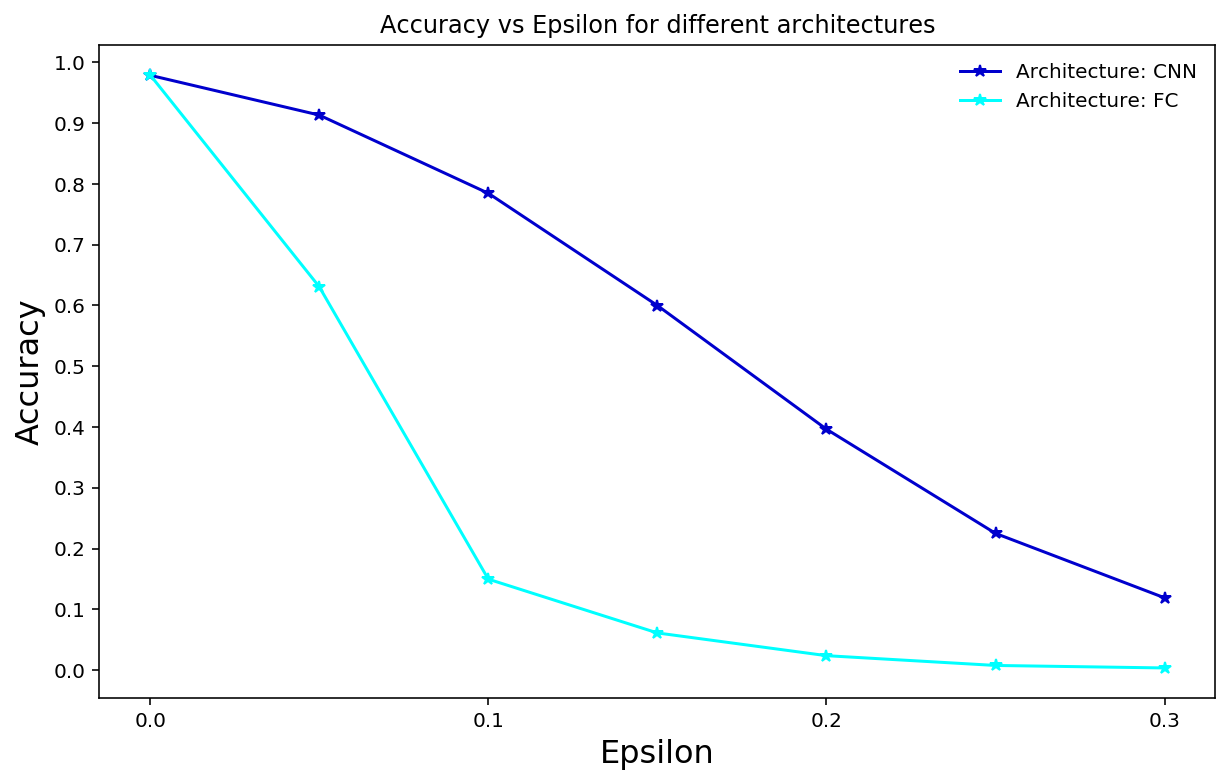

In [3]:
data = {
    'CNN': [0.978725, 0.91325 , 0.784575, 0.599875, 0.396325, 0.224875, 0.11885],
    'FC': [0.9793, 0.6308, 0.1496, 0.0611, 0.0237, 0.0076, 0.0035]

}
epsilons = [0, .05, .1, .15, .2, .25, .3]


# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))
colors =  ['mediumblue', 'aqua']

for idx, (arch, results) in enumerate(data.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label="Architecture: {}".format(arch))

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.31, step=0.1))
plt.title("Accuracy vs Epsilon for different architectures")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()